<a href="https://colab.research.google.com/github/huhjayeon/cbm-prediction-model/blob/main/cbm_prediction_Stacking_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install "dask[dataframe]"


INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 5.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Stacking 모델 테스트 데이터 MAE: 0.09
Stacking 모델 테스트 데이터 RMSE: 0.69


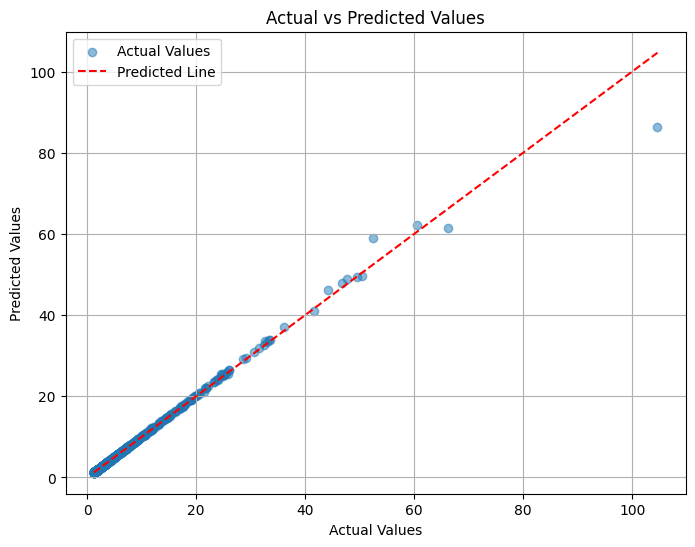

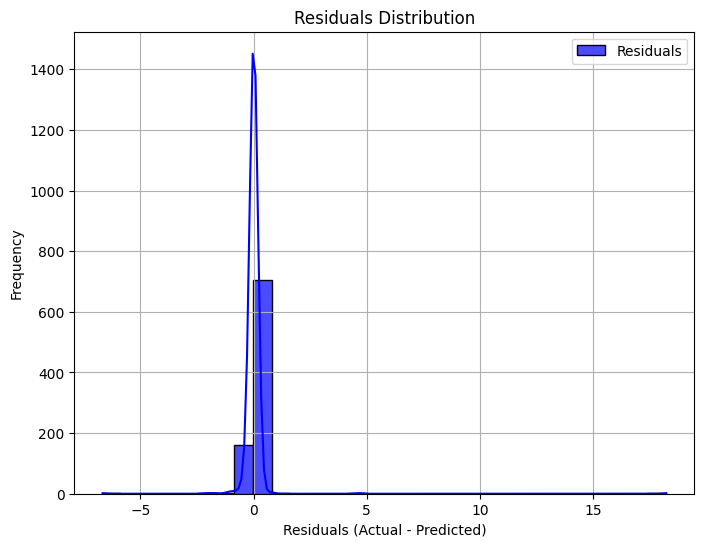

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
import numpy as np

# 데이터 로드
pckg_cbm = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cms/data/cbm/tb_pckg_cbm_fin.csv')
pckg_prod = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/cms/data/cbm/tb_pckg_prod_fin.csv')

# 데이터 전처리
# SKU 종류와 수량 계산
sku_count = pckg_prod.groupby('pckg_no')['prod_cd'].nunique().reset_index()
sku_count.rename(columns={'prod_cd': 'sku_count'}, inplace=True)

total_qty = pckg_prod.groupby('pckg_no')['qty'].sum().reset_index()
total_qty.rename(columns={'qty': 'total_qty'}, inplace=True)

# SKU 총 부피 계산
sku_total_volume = pckg_prod.groupby('pckg_no')['total_prod_volume'].sum().reset_index()
sku_total_volume.rename(columns={'total_prod_volume': 'sku_total_volume'}, inplace=True)

# 패킹 데이터와 병합
pallet_total_cbm = pckg_cbm[['pckg_no', 'total_pckg_cbm']].drop_duplicates()
merged_data = pd.merge(sku_total_volume, pallet_total_cbm, on='pckg_no')
merged_data = pd.merge(merged_data, sku_count, on='pckg_no')
merged_data = pd.merge(merged_data, total_qty, on='pckg_no')

# 팔레트 높이 추가
merged_data['pallet_height'] = merged_data['total_pckg_cbm'] / (1.1 * 1.1)  # 가로와 세로는 1.1m 고정

# 패킹넘버별 팔레트 개수 계산
pallet_counts = pckg_cbm.groupby('pckg_no').size().reset_index(name='pallet_count')

# 팔레트 개수와 최대 가능한 부피 계산
pallet_counts['max_possible_cbm'] = pallet_counts['pallet_count'] * (1.1 * 1.1 * 2.4)  # 1.1m x 1.1m x 2.4m

# 패킹 데이터와 병합
merged_with_counts = pd.merge(merged_data, pallet_counts, on='pckg_no')

# 이상치 탐지 (실제 total_pckg_cbm > max_possible_cbm)
outliers = merged_with_counts[merged_with_counts['total_pckg_cbm'] > merged_with_counts['max_possible_cbm']]

# 이상치 제거
filtered_data = merged_with_counts[merged_with_counts['total_pckg_cbm'] <= merged_with_counts['max_possible_cbm']]

# 독립 변수와 종속 변수 설정
X = filtered_data[['sku_total_volume', 'sku_count', 'total_qty', 'pallet_height']]
y = filtered_data['total_pckg_cbm']

# 하한값 설정 (y > 1.21)
lower_bound = 1.21
valid_indices = y[y > lower_bound].index
X = X.loc[valid_indices]
y = y.loc[valid_indices]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 베이스 모델 설정
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)
lgbm_model = LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=5, random_state=42)

# 메타 모델 설정
meta_model = LinearRegression()

# Stacking Regressor 설정
stacking_model = StackingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ],
    final_estimator=meta_model,
    cv=5,  # K-fold Cross Validation
    n_jobs=-1
)

# 모델 학습
stacking_model.fit(X_train, y_train)

# 예측 및 평가
y_test_pred = stacking_model.predict(X_test)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"Stacking 모델 테스트 데이터 MAE: {mae:.2f}")
print(f"Stacking 모델 테스트 데이터 RMSE: {rmse:.2f}")

# 시각화: 실제값 vs 예측값
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, label="Actual Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Predicted Line")
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid()
plt.show()

# 시각화: 잔차 분포
residuals = y_test - y_test_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='blue', alpha=0.7, label="Residuals")
plt.title("Residuals Distribution")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()


In [4]:
# K-fold Cross Validation 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross Validation 수행
cv_scores = cross_val_score(stacking_model, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1)

print(f"Cross-Validation MAE Scores: {-cv_scores}")
print(f"Average MAE: {-np.mean(cv_scores):.2f}")


Cross-Validation MAE Scores: [0.100793   0.09872606 0.17298961 0.20035178 0.13299903]
Average MAE: 0.14
